In [2]:
import pandas as pd
import geopandas
import plotly.express as px
import os
from geopandas import GeoDataFrame
from shapely.geometry import Point
import matplotlib.pyplot as plt
import imageio
import mapclassify
import matplotlib
import warnings
warnings.filterwarnings("ignore")
import matplotlib.image as mpimg
import ast
import json

In [3]:
visitors_2018 = pd.read_csv('/Volumes/xuyilun/课题/Human Dynamics/safegraph/GOOGLEDRIVES/data/All_stores_total_visitors_2018.csv').drop(
    columns = ['Unnamed: 0','total_visitors'], axis =1)
visitors_2019 = pd.read_csv('/Volumes/xuyilun/课题/Human Dynamics/safegraph/GOOGLEDRIVES/data/All_stores_total_visitors_2019.csv').drop(
    columns = ['Unnamed: 0','total_visitors'], axis =1)
location = pd.read_csv('/Volumes/xuyilun/课题/Human Dynamics/safegraph/GOOGLEDRIVES/data/all_info_after_aggregation.csv').drop(
    columns = ['Unnamed: 0'], axis =1)

In [4]:
location['longitude'] = location['geo'].apply(lambda x:ast.literal_eval(x)[1])
location['latitude'] = location['geo'].apply(lambda x:ast.literal_eval(x)[0])
geometry = [Point(xy) for xy in zip(location.longitude, location.latitude)]
location = location.drop(['longitude', 'latitude','geo'], axis=1)
location = GeoDataFrame(location, crs="EPSG:4326", geometry=geometry)

In [5]:
info_dict = {}
for i,cont in location.iterrows():
    info_dict[cont['safegraph_place_id']] = cont['geometry']

In [7]:
with open('/Volumes/xuyilun/课题/Human Dynamics/safegraph/nyc_cbgs.json') as f:
    cbg_data = json.load(f)
cbg_info = cbg_data['features']
cbgs = visitors_2018.cbg.tolist()

In [9]:
shp_path = '/Volumes/xuyilun/课题/Human Dynamics/safegraph/tl_2017_36_bg/tl_2017_36_bg.shp'

In [10]:
shp_df = geopandas.GeoDataFrame.from_file(shp_path,encoding = 'gb18030')
#shp_df = shp_df[shp_df['GEOID'].isin(nyc_cbg)].reset_index()

In [11]:
cbg_info = {}
cbg_id = shp_df['GEOID'].tolist()
cbg_geo = shp_df['geometry'].tolist()
for i in range(len(cbg_id)):
    cbg_info[cbg_id[i]] = cbg_geo[i]

In [12]:
visitors_2018['cbg_geometry'] = visitors_2018['cbg'].apply(lambda x: cbg_info[str(x)])
visitors_2019['cbg_geometry'] = visitors_2019['cbg'].apply(lambda x: cbg_info[str(x)])

In [13]:
base_targets_2018 = {'sg:c843f07483c04a22960814f2d859ec04': 'visits loss based, revenue loss based',
                    'sg:84898e686e71419b805d5212ae814111': 'visits number based, revenue proxy based',
                    'sg:cffe77a3b2f543af9387cdc0a69cb0b8': 'diversity based'}
base_targets_2019 = {'sg:3275834c58d241baacdb9965f5003af6': 'visits loss based', 'sg:c843f07483c04a22960814f2d859ec04': 'revenue loss based',
                    'sg:84898e686e71419b805d5212ae814111': 'visits number based, revenue proxy based',
                    'sg:cffe77a3b2f543af9387cdc0a69cb0b8': 'diversity based'}

In [14]:
def get_base_targets_location(dictionary):
    bases = list(dictionary.keys())
    temp = location[location['safegraph_place_id'].isin(bases)]
    temp['text'] = list(dictionary.values())
    return temp

In [15]:
def get_closed_bases(year):
    if year == 2018:
        temp = visitors_2018.copy()
        temp_5_targets = get_base_targets_location(base_targets_2018)
    else:
        temp = visitors_2019.copy()
        temp_5_targets = get_base_targets_location(base_targets_2019)
    p = GeoDataFrame(temp,geometry = 'cbg_geometry')
    fig, ax = plt.subplots(1, 1, figsize=[15,10])
    p.plot(ax=ax, color='white', edgecolor='orange',linewidth=0.2)
    temp_5_targets.plot(ax=ax, marker='o', color = 'green', markersize=20)
    for x, y, label,text in zip(temp_5_targets.geometry.x, temp_5_targets.geometry.y, temp_5_targets.safegraph_place_id, temp_5_targets.text):
        string = 'Closed Store ('+ text +')'
        ax.annotate(string, xy=(x, y), xytext=(3, 3), textcoords="offset points")
    plt.suptitle('Suggested Stores to be Closed',size = 20)
    plt.title('based on data in ' + str(year), size = 12, pad=20, loc='center')
    plt.axis('off')
    save_path = '/Volumes/xuyilun/课题/Human Dynamics/safegraph/GOOGLEDRIVES/figures/Suggested_closed_stores/Suggested_Stores_to_be_Closed_'+str(year) +' (5 standards).png'
    plt.savefig(save_path,dpi=100)

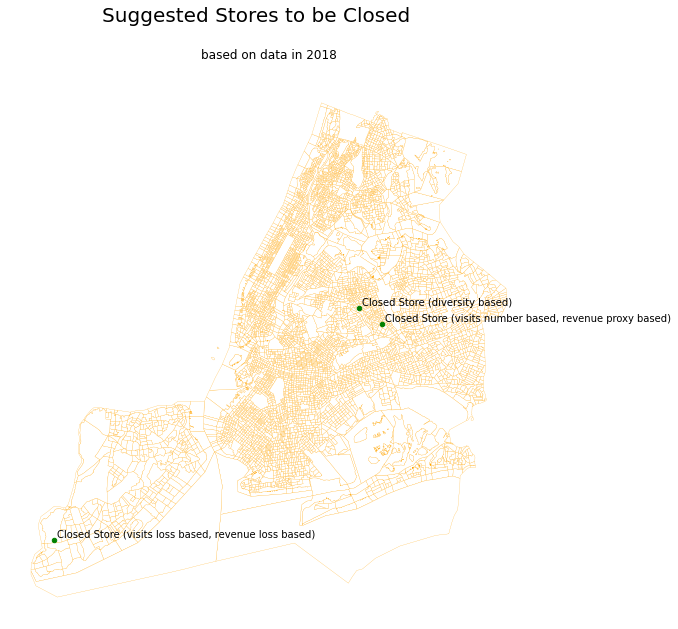

In [16]:
get_closed_bases(2018)

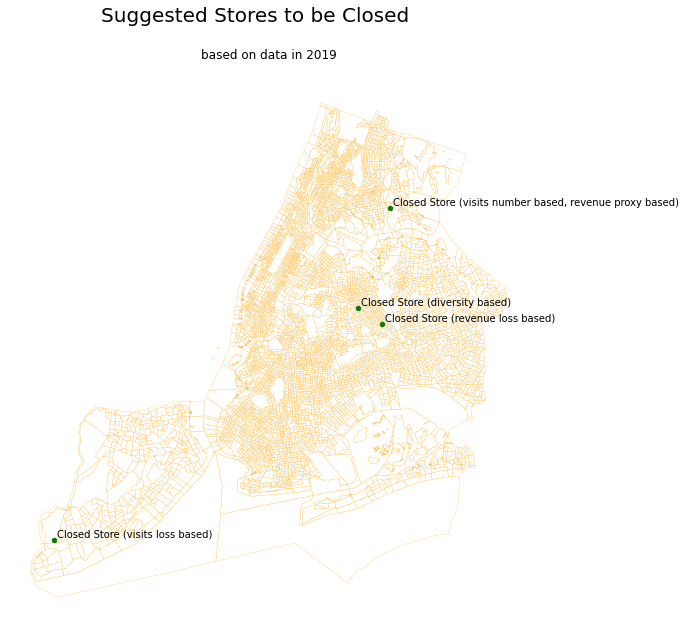

In [17]:
get_closed_bases(2019)